In [223]:
import featuretools as ft
from sklearn.metrics import confusion_matrix,auc,accuracy_score,roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from featuretools_tsfresh_primitives import AbsEnergy
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [2]:
train=pd.read_csv("../data/train.csv")
compaign=pd.read_csv("../data/campaign_data.csv")
coupon_item_mapping=pd.read_csv("../data/coupon_item_mapping.csv")
customer_demographics=pd.read_csv("../data/customer_demographics.csv")
customer_transaction=pd.read_csv("../data/customer_transaction_data.csv")
item=pd.read_csv("../data/item_data.csv")
test=pd.read_csv("../data/test_QyjYwdj.csv")

In [3]:
train.head()
compaign.head()
coupon_item_mapping.head()
customer_demographics.head()
customer_transaction.head()
item.head()
test.head()

,id,campaign_id,coupon_id,customer_id,redemption_status
0,1,13,27,1053,0
1,2,13,116,48,0
2,6,9,635,205,0
3,7,13,644,1050,0
4,9,8,1017,1489,0


,campaign_id,campaign_type,start_date,end_date
0,24,Y,21/10/13,20/12/13
1,25,Y,21/10/13,22/11/13
2,20,Y,07/09/13,16/11/13
3,23,Y,08/10/13,15/11/13
4,21,Y,16/09/13,18/10/13


,coupon_id,item_id
0,105,37
1,107,75
2,494,76
3,522,77
4,518,77


,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,NaN,4
1,6,46-55,Married,0,2,NaN,5
2,7,26-35,NaN,0,3,1,3
3,8,26-35,NaN,0,4,2,6
4,10,46-55,Single,0,1,NaN,5


,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
0,2012-01-02,1501,26830,1,35.26,-10.69,0.0
1,2012-01-02,1501,54253,1,53.43,-13.89,0.0
2,2012-01-02,1501,31962,1,106.50,-14.25,0.0
3,2012-01-02,1501,33647,1,67.32,0.00,0.0
4,2012-01-02,1501,48199,1,71.24,-28.14,0.0


,item_id,brand,brand_type,category
0,1,1,Established,Grocery
1,2,1,Established,Miscellaneous
2,3,56,Local,Bakery
3,4,56,Local,Grocery
4,5,56,Local,Grocery


,id,campaign_id,coupon_id,customer_id
0,3,22,869,967
1,4,20,389,1566
2,5,22,981,510
3,8,25,1069,361
4,10,17,498,811


In [4]:
label=train.pop("redemption_status")
label.value_counts()

0    77640
1      729
Name: redemption_status, dtype: int64

In [30]:
item.nunique()

item_id       74066
brand          5528
brand_type        2
category         19
dtype: int64

In [84]:
train_vartypes={"id":ft.variable_types.Index,"campaign_id":ft.variable_types.Id,"coupon_id":ft.variable_types.Id,"customer_id":ft.variable_types.Id}
train_vartypes
compaign_vartypes={"campaign_type":ft.variable_types.Categorical,"start_date":ft.variable_types.Datetime,"end_date":ft.variable_types.Datetime}
compaign_vartypes
coupon_varttypes={"coupon_id":ft.variable_types.Id,"item_id":ft.variable_types.Id}
coupon_varttypes
cust_demovartypes={"customer_id":ft.variable_types.Id,
                   "age_range":ft.variable_types.Categorical,
                    "marital_status":ft.variable_types.Categorical,
                    "rented":ft.variable_types.Categorical,
                     "family_size":ft.variable_types.Categorical,
                      "no_of_children":ft.variable_types.Categorical,
                      "income_bracket":ft.variable_types.Categorical}
cust_demovartypes
cust_trans_vartypes={
        "date":ft.variable_types.Datetime,
        "customer_id":ft.variable_types.Id,
        "item_id":ft.variable_types.Id,
        "quantity":ft.variable_types.Numeric,
        "selling_price":ft.variable_types.Numeric,
        "other_discount":ft.variable_types.Numeric,
        "coupon_discount":ft.variable_types.Numeric
}
cust_trans_vartypes
item_vartypes={
    "brand":ft.variable_types.Categorical,
    "brand_type":ft.variable_types.Categorical,
    "category":ft.variable_types.Categorical
}
item_vartypes

{'id': featuretools.variable_types.variable.Index,
 'campaign_id': featuretools.variable_types.variable.Id,
 'coupon_id': featuretools.variable_types.variable.Id,
 'customer_id': featuretools.variable_types.variable.Id}

{'campaign_type': featuretools.variable_types.variable.Categorical,
 'start_date': featuretools.variable_types.variable.Datetime,
 'end_date': featuretools.variable_types.variable.Datetime}

{'coupon_id': featuretools.variable_types.variable.Id,
 'item_id': featuretools.variable_types.variable.Id}

{'customer_id': featuretools.variable_types.variable.Id,
 'age_range': featuretools.variable_types.variable.Categorical,
 'marital_status': featuretools.variable_types.variable.Categorical,
 'rented': featuretools.variable_types.variable.Categorical,
 'family_size': featuretools.variable_types.variable.Categorical,
 'no_of_children': featuretools.variable_types.variable.Categorical,
 'income_bracket': featuretools.variable_types.variable.Categorical}

{'date': featuretools.variable_types.variable.Datetime,
 'customer_id': featuretools.variable_types.variable.Id,
 'item_id': featuretools.variable_types.variable.Id,
 'quantity': featuretools.variable_types.variable.Numeric,
 'selling_price': featuretools.variable_types.variable.Numeric,
 'other_discount': featuretools.variable_types.variable.Numeric,
 'coupon_discount': featuretools.variable_types.variable.Numeric}

{'brand': featuretools.variable_types.variable.Categorical,
 'brand_type': featuretools.variable_types.variable.Categorical,
 'category': featuretools.variable_types.variable.Categorical}

In [92]:
#coupon_item_mapping=coupon_item_mapping.drop("coupon_index",axis=1)
#customer_transaction=customer_transaction.drop("transaction_index",axis=1)

In [91]:
es = ft.EntitySet(id = 'AVP')
es= es.entity_from_dataframe(entity_id = 'train', dataframe = train, 
                              index = 'id',variable_types=train_vartypes)
es=es.entity_from_dataframe(entity_id="compaign",dataframe=compaign,
                            index='campaign_id',variable_types=compaign_vartypes)
es=es.entity_from_dataframe(entity_id="coupon_item_mapping", dataframe=coupon_item_mapping,
                            index="coupon_index",make_index=True,
                            variable_types=coupon_varttypes)
es=es.entity_from_dataframe(entity_id="customer_demographics",
                            dataframe=customer_demographics,variable_types=cust_demovartypes,
                            index="customer_id")
es=es.entity_from_dataframe(entity_id="customer_transaction",
                            dataframe=customer_transaction,
                            index="transaction_index",make_index=True,variable_types=cust_trans_vartypes)
es=es.entity_from_dataframe(entity_id="item",dataframe=item,index="item_id",variable_types=item_vartypes)

es

Entityset: AVP
  Entities:
    train [Rows: 78369, Columns: 4]
    compaign [Rows: 28, Columns: 4]
    coupon_item_mapping [Rows: 92663, Columns: 3]
    customer_demographics [Rows: 760, Columns: 7]
    customer_transaction [Rows: 1324566, Columns: 8]
    item [Rows: 74066, Columns: 4]
  Relationships:
    No relationships

In [93]:
train_compaign = ft.Relationship(es['compaign']['campaign_id'],es['train']['campaign_id'])
#es.add_relationship(train_compaign)
#train_coupon=ft.Relationship(es['train']['coupon_id'],es['coupon_item_mapping']["coupon_id"])
train_cust_demog=ft.Relationship(es['customer_demographics']['customer_id'],es['train']['customer_id'])

cust_demog_trans=ft.Relationship(es['customer_demographics']['customer_id'],es['customer_transaction']['customer_id'])
cust_trans_item=ft.Relationship(es['item']['item_id'],es['customer_transaction']['item_id'])
item_coupon=ft.Relationship(es['item']['item_id'],es['coupon_item_mapping']['item_id'])

Entityset: AVP
  Entities:
    train [Rows: 78369, Columns: 4]
    compaign [Rows: 28, Columns: 4]
    coupon_item_mapping [Rows: 92663, Columns: 3]
    customer_demographics [Rows: 760, Columns: 7]
    customer_transaction [Rows: 1324566, Columns: 8]
    item [Rows: 74066, Columns: 4]
  Relationships:
    train.campaign_id -> compaign.campaign_id
    train.customer_id -> customer_demographics.customer_id
    customer_transaction.customer_id -> customer_demographics.customer_id
    customer_transaction.item_id -> item.item_id
    coupon_item_mapping.item_id -> item.item_id

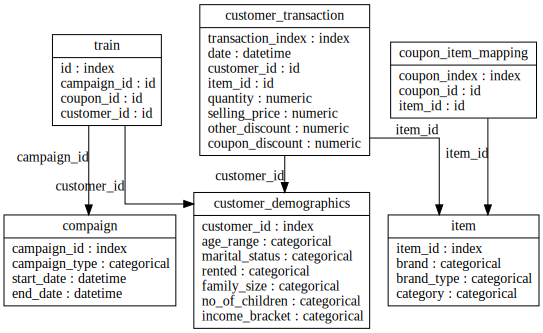

In [95]:
es.add_relationships([train_compaign,train_cust_demog,cust_demog_trans,cust_trans_item,item_coupon])
es.plot()

In [107]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    pd.set_option('max_colwidth', 500)  # more options can be specified also
    ft.primitives.list_primitives()


,name,type,description
0,last,aggregation,Determines the last value in a list.
1,sum,aggregation,"Calculates the total addition, ignoring `NaN`."
2,std,aggregation,"Computes the dispersion relative to the mean value, ignoring `NaN`."
3,num_unique,aggregation,"Determines the number of distinct values, ignoring `NaN` values."
4,avg_time_between,aggregation,Computes the average number of seconds between consecutive events.
5,time_since_first,aggregation,Calculates the time elapsed since the first datetime (in seconds).
6,median,aggregation,Determines the middlemost number in a list of values.
7,min,aggregation,"Calculates the smallest value, ignoring `NaN` values."
8,percent_true,aggregation,Determines the percent of `True` values.
9,max,aggregation,"Calculates the highest value, ignoring `NaN` values."


In [135]:
agg_primitives=[
        'std', 'min', 'max', 'mean', 
        'percent_true', 'last', 'count','sum',
        'trend', 'n_most_common', 'time_since_last',        
        'avg_time_between','time_since_first'
]
trans_primitives=[
        'year', 'month', 'weekday', 'percentile', 
        'cum_mean','hour','week',
        'time_since_previous','is_weekend','cum_sum'
]
# I'll go over this below
where_primitives = ['std', 'min', 'max', 'mean', 'count']


In [145]:
ignore_varaibles={"train":['campaign_id', 'coupon_id', 'customer_id', 'item_id','id'],"compaign":["compaign_id"],"coupon_item_mapping":["coupon_id","coupon_index"],"customer_demographics":["customer_id"],
        "customer_transaction":["customer_id","transaction_index","item_id"],"item":["item_id"]}
ignore_varaibles

{'train': ['campaign_id', 'coupon_id', 'customer_id', 'item_id', 'id'],
 'compaign': ['compaign_id'],
 'coupon_item_mapping': ['coupon_id', 'coupon_index'],
 'customer_demographics': ['customer_id'],
 'customer_transaction': ['customer_id', 'transaction_index', 'item_id'],
 'item': ['item_id']}

In [146]:
feature_matrix, feature_names = ft.dfs(entityset=es, 
                                        target_entity = 'train', 
                                        max_depth = 3,
                                        agg_primitives=agg_primitives,
                                        trans_primitives=trans_primitives,
                                        verbose = True,
                                        ignore_variables=ignore_varaibles)



Built 227 features
Elapsed: 00:20 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


In [147]:
feature_names

[<Feature: compaign.campaign_type>,
 <Feature: customer_demographics.age_range>,
 <Feature: customer_demographics.marital_status>,
 <Feature: customer_demographics.rented>,
 <Feature: customer_demographics.family_size>,
 <Feature: customer_demographics.no_of_children>,
 <Feature: customer_demographics.income_bracket>,
 <Feature: compaign.YEAR(start_date)>,
 <Feature: compaign.YEAR(end_date)>,
 <Feature: compaign.MONTH(start_date)>,
 <Feature: compaign.MONTH(end_date)>,
 <Feature: compaign.WEEKDAY(start_date)>,
 <Feature: compaign.WEEKDAY(end_date)>,
 <Feature: compaign.HOUR(start_date)>,
 <Feature: compaign.HOUR(end_date)>,
 <Feature: compaign.WEEK(start_date)>,
 <Feature: compaign.WEEK(end_date)>,
 <Feature: compaign.IS_WEEKEND(start_date)>,
 <Feature: compaign.IS_WEEKEND(end_date)>,
 <Feature: customer_demographics.STD(customer_transaction.quantity)>,
 <Feature: customer_demographics.STD(customer_transaction.selling_price)>,
 <Feature: customer_demographics.STD(customer_transaction.o

In [148]:
feature_matrix.head()

,compaign.campaign_type,customer_demographics.age_range,customer_demographics.marital_status,customer_demographics.rented,customer_demographics.family_size,customer_demographics.no_of_children,customer_demographics.income_bracket,compaign.YEAR(start_date),compaign.YEAR(end_date),compaign.MONTH(start_date),...,customer_demographics.N_MOST_COMMON(customer_transaction.WEEK(date))[2],customer_demographics.N_MOST_COMMON(customer_transaction.item.brand)[0],customer_demographics.N_MOST_COMMON(customer_transaction.item.brand)[1],customer_demographics.N_MOST_COMMON(customer_transaction.item.brand)[2],customer_demographics.N_MOST_COMMON(customer_transaction.item.brand_type)[0],customer_demographics.N_MOST_COMMON(customer_transaction.item.brand_type)[1],customer_demographics.N_MOST_COMMON(customer_transaction.item.brand_type)[2],customer_demographics.N_MOST_COMMON(customer_transaction.item.category)[0],customer_demographics.N_MOST_COMMON(customer_transaction.item.category)[1],customer_demographics.N_MOST_COMMON(customer_transaction.item.category)[2]
id,,,,,,,,,,,,,,,,,,,,,
1,X,46-55,NaN,0.0,1,NaN,5.0,2013,2013,5,...,6.0,56.0,212.0,369.0,Established,Local,NaN,Grocery,Packaged Meat,Pharmaceutical
2,X,36-45,Married,0.0,2,NaN,3.0,2013,2013,5,...,25.0,56.0,482.0,1.0,Established,Local,NaN,Grocery,Pharmaceutical,Packaged Meat
6,Y,46-55,Married,0.0,2,NaN,7.0,2013,2013,11,...,12.0,56.0,1337.0,1088.0,Established,Local,NaN,Grocery,Pharmaceutical,Meat
7,X,NaN,NaN,NaN,NaN,NaN,NaN,2013,2013,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,X,46-55,Married,0.0,2,NaN,3.0,2013,2013,2,...,19.0,56.0,1235.0,2025.0,Established,Local,NaN,Grocery,Packaged Meat,Pharmaceutical


In [149]:
feature_matrix_enc, features_enc = ft.encode_features(feature_matrix, feature_names)


In [151]:
feature_matrix_enc.head()

,compaign.campaign_type = X,compaign.campaign_type = Y,compaign.campaign_type is unknown,customer_demographics.age_range = 46-55,customer_demographics.age_range = 36-45,customer_demographics.age_range = 26-35,customer_demographics.age_range = 56-70,customer_demographics.age_range = 70+,customer_demographics.age_range = 18-25,customer_demographics.age_range is unknown,...,customer_demographics.N_MOST_COMMON(customer_transaction.item.category)[2] = Natural Products,customer_demographics.N_MOST_COMMON(customer_transaction.item.category)[2] = Pharmaceutical,"customer_demographics.N_MOST_COMMON(customer_transaction.item.category)[2] = Dairy, Juices & Snacks",customer_demographics.N_MOST_COMMON(customer_transaction.item.category)[2] = Meat,customer_demographics.N_MOST_COMMON(customer_transaction.item.category)[2] = Fuel,customer_demographics.N_MOST_COMMON(customer_transaction.item.category)[2] = Bakery,customer_demographics.N_MOST_COMMON(customer_transaction.item.category)[2] = Prepared Food,customer_demographics.N_MOST_COMMON(customer_transaction.item.category)[2] = Skin & Hair Care,customer_demographics.N_MOST_COMMON(customer_transaction.item.category)[2] = Alcohol,customer_demographics.N_MOST_COMMON(customer_transaction.item.category)[2] is unknown
id,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,1,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
9,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [153]:
feature_matrix_enc.isnull().sum()

compaign.campaign_type = X                                                                             0
compaign.campaign_type = Y                                                                             0
compaign.campaign_type is unknown                                                                      0
customer_demographics.age_range = 46-55                                                                0
customer_demographics.age_range = 36-45                                                                0
customer_demographics.age_range = 26-35                                                                0
customer_demographics.age_range = 56-70                                                                0
customer_demographics.age_range = 70+                                                                  0
customer_demographics.age_range = 18-25                                                                0
customer_demographics.age_range is unknown             

In [156]:
es_test = ft.EntitySet(id = 'AVP')
es_test= es_test.entity_from_dataframe(entity_id = 'train', dataframe = test, 
                              index = 'id',variable_types=train_vartypes)


In [159]:
es_test=es_test.entity_from_dataframe(entity_id="compaign",dataframe=compaign,
                            index='campaign_id',variable_types=compaign_vartypes)
es_test=es_test.entity_from_dataframe(entity_id="coupon_item_mapping", dataframe=coupon_item_mapping,
                            index="coupon_index",#make_index=True,
                            variable_types=coupon_varttypes)
es_test=es_test.entity_from_dataframe(entity_id="customer_demographics",
                            dataframe=customer_demographics,variable_types=cust_demovartypes,
                            index="customer_id")
es_test=es_test.entity_from_dataframe(entity_id="customer_transaction",
                            dataframe=customer_transaction,
                            index="transaction_index",#make_index=True,
                                      variable_types=cust_trans_vartypes)
es_test=es_test.entity_from_dataframe(entity_id="item",dataframe=item,index="item_id",variable_types=item_vartypes)
es_test


Entityset: AVP
  Entities:
    train [Rows: 50226, Columns: 4]
    compaign [Rows: 28, Columns: 4]
    coupon_item_mapping [Rows: 92663, Columns: 3]
    customer_demographics [Rows: 760, Columns: 7]
    customer_transaction [Rows: 1324566, Columns: 8]
    item [Rows: 74066, Columns: 4]
  Relationships:
    No relationships

Entityset: AVP
  Entities:
    train [Rows: 50226, Columns: 4]
    compaign [Rows: 28, Columns: 4]
    coupon_item_mapping [Rows: 92663, Columns: 3]
    customer_demographics [Rows: 760, Columns: 7]
    customer_transaction [Rows: 1324566, Columns: 8]
    item [Rows: 74066, Columns: 4]
  Relationships:
    train.campaign_id -> compaign.campaign_id
    train.customer_id -> customer_demographics.customer_id
    customer_transaction.customer_id -> customer_demographics.customer_id
    customer_transaction.item_id -> item.item_id
    coupon_item_mapping.item_id -> item.item_id

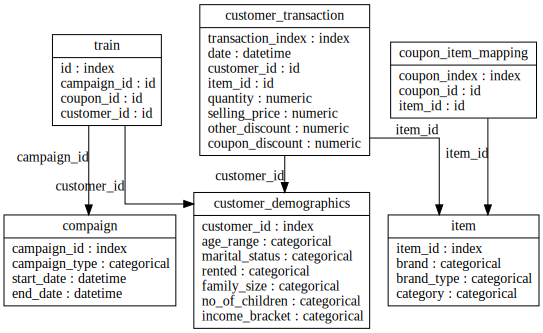

In [160]:
es_test.add_relationships([train_compaign,train_cust_demog,cust_demog_trans,cust_trans_item,item_coupon])
es_test.plot()

In [161]:
#saved_features = ft.load_features('feature_train.json')
test_feat=ft.calculate_feature_matrix(features_enc, es_test)

In [168]:
assert test_feat.shape[1]==feature_matrix_enc.shape[1] # ensure same number of columns
assert test.shape[0]==test_feat.shape[0]
assert train.shape[0]==train.shape[0]

In [170]:
test_feat.head()
test.head()

,compaign.campaign_type = X,compaign.campaign_type = Y,compaign.campaign_type is unknown,customer_demographics.age_range = 46-55,customer_demographics.age_range = 36-45,customer_demographics.age_range = 26-35,customer_demographics.age_range = 56-70,customer_demographics.age_range = 70+,customer_demographics.age_range = 18-25,customer_demographics.age_range is unknown,...,customer_demographics.N_MOST_COMMON(customer_transaction.item.category)[2] = Natural Products,customer_demographics.N_MOST_COMMON(customer_transaction.item.category)[2] = Pharmaceutical,"customer_demographics.N_MOST_COMMON(customer_transaction.item.category)[2] = Dairy, Juices & Snacks",customer_demographics.N_MOST_COMMON(customer_transaction.item.category)[2] = Meat,customer_demographics.N_MOST_COMMON(customer_transaction.item.category)[2] = Fuel,customer_demographics.N_MOST_COMMON(customer_transaction.item.category)[2] = Bakery,customer_demographics.N_MOST_COMMON(customer_transaction.item.category)[2] = Prepared Food,customer_demographics.N_MOST_COMMON(customer_transaction.item.category)[2] = Skin & Hair Care,customer_demographics.N_MOST_COMMON(customer_transaction.item.category)[2] = Alcohol,customer_demographics.N_MOST_COMMON(customer_transaction.item.category)[2] is unknown
id,,,,,,,,,,,,,,,,,,,,,
3,True,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,True,False,False,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
5,True,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,False,True,False,False,False,False,False,False,True,False,...,True,False,False,False,False,False,False,False,False,False
10,False,True,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True


,id,campaign_id,coupon_id,customer_id
0,3,22,869,967
1,4,20,389,1566
2,5,22,981,510
3,8,25,1069,361
4,10,17,498,811


## Modeling

In [171]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

In [173]:
feature_matrix_enc=feature_matrix_enc.fillna(999)


In [185]:
rf=RandomForestClassifier(n_estimators=300,verbose=True,class_weight={0:0.3,1:0.7},n_jobs=-1)
rf.fit(feature_matrix_enc,label)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   46.9s finished


RandomForestClassifier(bootstrap=True, class_weight={0: 0.3, 1: 0.7},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False,
            random_state=None, verbose=True, warm_start=False)

In [186]:
# Training score
pred=rf.predict(feature_matrix_enc)
np.mean(pred==label)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    1.9s finished


0.990506450254565

In [221]:
np.unique(pred,return_counts=True),np.unique(label,return_counts=True)

((array([0, 1], dtype=int64), array([78312,    57], dtype=int64)),
 (array([0, 1], dtype=int64), array([77640,   729], dtype=int64)))

(array([  0.,  20.,  40.,  60.,  80., 100.]),
 <a list of 6 Text xticklabel objects>)

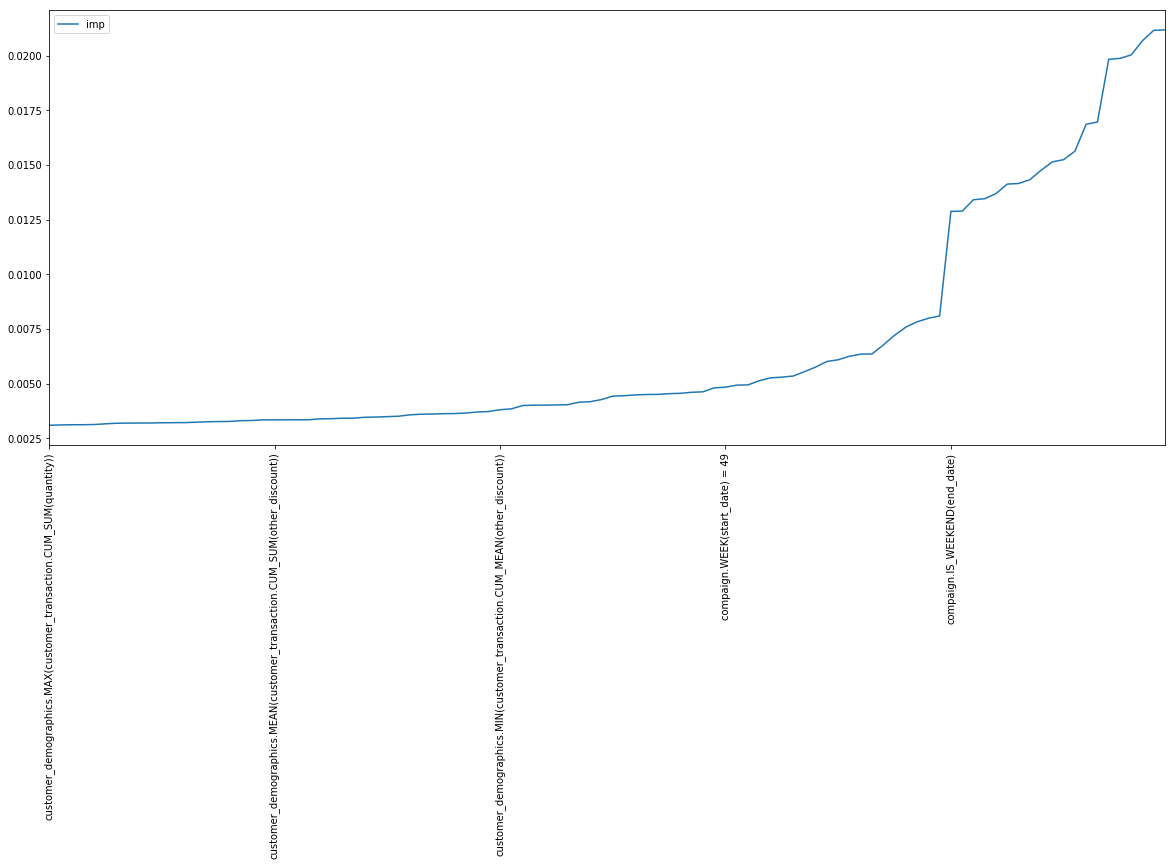

In [209]:
pd.DataFrame(rf.feature_importances_,index=feature_matrix_enc.columns,columns=['imp']).\
                        sort_values(by='imp')[-100:].plot(figsize=(20,8))
plt.xticks(rotation="vertical")
plt.show()

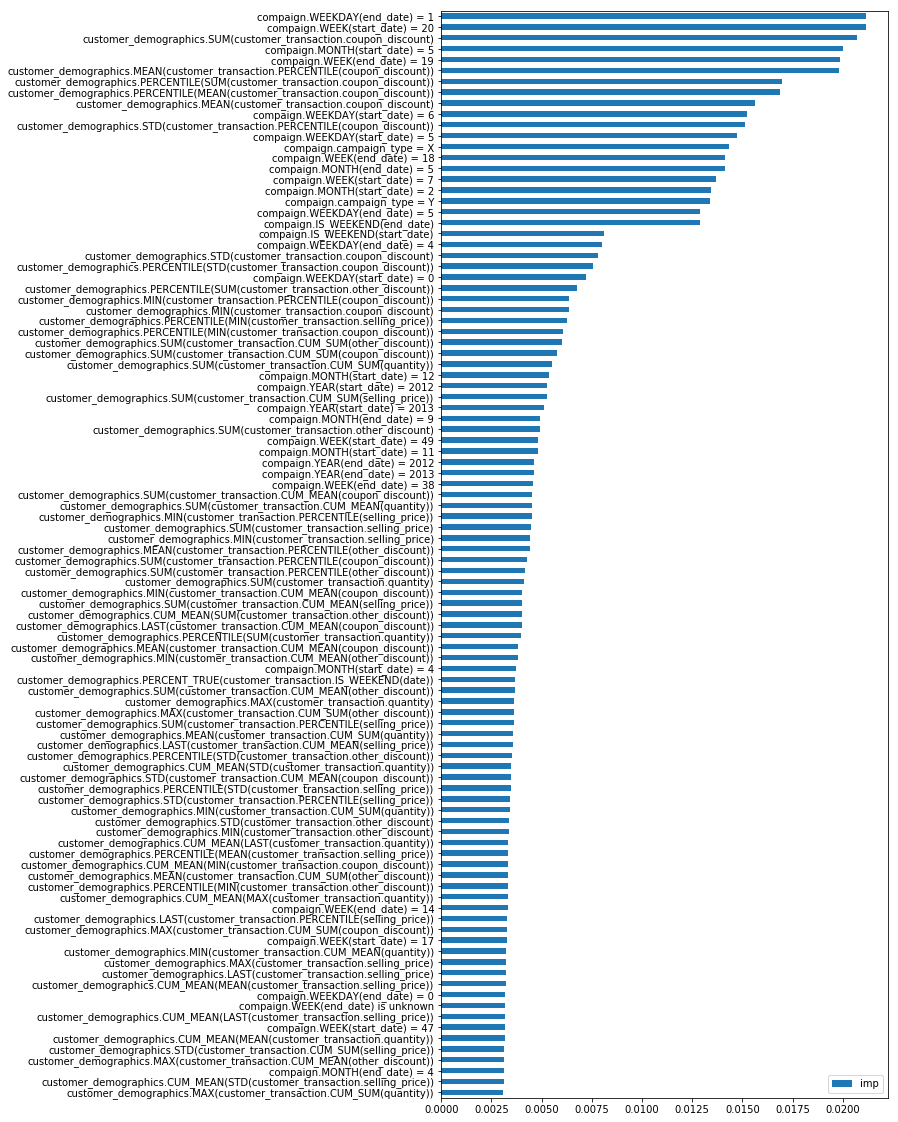

In [203]:
pd.DataFrame(rf.feature_importances_,index=feature_matrix_enc.columns,columns=['imp']).\
                        sort_values(by='imp')[-100:].plot(kind='barh',figsize=(8,20))
plt.show()

In [216]:
ref_feat=np.array(feature_matrix_enc.columns)[np.where(rf.feature_importances_>0.0002)]

In [225]:
def eval_model(model,X_train,X_test=None):
    if not X_test:
        X_test=X_train
    model.fit(X_train,label)
    pred=model.predict(X_train)
    res={
        "auc":roc_auc_score(label,pred),
        "cm":confusion_matrix(label,pred),
        "auccarcy":np.mean(pred==label)
    }
    return res

In [219]:
rf=RandomForestClassifier(n_estimators=300,verbose=True,class_weight={0:0.2,1:0.8},n_jobs=-1)
rf.fit(feature_matrix_enc[ref_feat],label)
# Training score
pred=rf.predict(feature_matrix_enc[ref_feat])
np.mean(pred==label)
np.unique(pred,return_counts=True),np.unique(label,return_counts=True)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   38.1s finished


RandomForestClassifier(bootstrap=True, class_weight={0: 0.3, 1: 0.7},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False,
            random_state=None, verbose=True, warm_start=False)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    1.9s finished


0.990506450254565

In [226]:
rf=RandomForestClassifier(n_estimators=300,verbose=True,class_weight={0:0.2,1:0.8},n_jobs=-1)
eval_model(rf,feature_matrix_enc[ref_feat])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   38.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    1.9s finished


{'auc': 0.5574586357208431, 'cm': array([[77403,   237],
        [  643,    86]], dtype=int64), 'auccarcy': 0.9887710701935715}

In [229]:
rf=GradientBoostingClassifier(n_estimators=300,verbose=True,)
eval_model(rf,feature_matrix_enc[ref_feat])

      Iter       Train Loss   Remaining Time 
         1           0.1007            5.66m
         2           0.0984            5.49m
         3           0.0966            5.35m
         4           0.0953            5.37m
         5           0.0944            5.30m
         6           0.0937            5.25m
         7           0.0930            5.32m
         8           0.0924            5.23m
         9           0.0920            5.19m
        10           0.0916            5.14m
        20           0.0888            4.91m
        30           0.0872            4.72m
        40           0.0861            4.50m
        50           0.0853            4.26m
        60           0.0847            4.05m
        70           0.0841            3.89m
        80           0.0836            3.69m
        90           0.0831            3.49m
       100           0.0826            3.35m
       200           0.0794            1.72m
       300           0.0776            0.00s


{'auc': 0.5006858710562414, 'cm': array([[77640,     0],
        [  728,     1]], dtype=int64), 'auccarcy': 0.9907106126146819}

In [231]:
rf=MLPClassifier(hidden_layer_sizes=[100,50,2],verbose=True,learning_rate='adaptive')
eval_model(rf,feature_matrix_enc[ref_feat])

Iteration 1, loss = 1.17368900
Iteration 2, loss = 0.93631887
Iteration 3, loss = 0.74295698
Iteration 4, loss = 0.58994983
Iteration 5, loss = 0.47084287
Iteration 6, loss = 0.37889000
Iteration 7, loss = 0.30802106
Iteration 8, loss = 0.25323265
Iteration 9, loss = 0.21065042
Iteration 10, loss = 0.17736329
Iteration 11, loss = 0.15117201
Iteration 12, loss = 0.13045714
Iteration 13, loss = 0.11399937
Iteration 14, loss = 0.10087451
Iteration 15, loss = 0.09038567
Iteration 16, loss = 0.08198948
Iteration 17, loss = 0.07528781
Iteration 18, loss = 0.06995826
Iteration 19, loss = 0.06573065
Iteration 20, loss = 0.06239583
Iteration 21, loss = 0.05979804
Iteration 22, loss = 0.05780034
Iteration 23, loss = 0.05627948
Iteration 24, loss = 0.05515062
Iteration 25, loss = 0.05433502
Iteration 26, loss = 0.05375846
Iteration 27, loss = 0.05337036
Iteration 28, loss = 0.05312130
Iteration 29, loss = 0.05296465
Iteration 30, loss = 0.05287417
Iteration 31, loss = 0.05282629
Iteration 32, los

{'auc': 0.5, 'cm': array([[77640,     0],
        [  729,     0]], dtype=int64), 'auccarcy': 0.9906978524671746}

In [232]:
from sklearn.feature_selection import RFE,GenericUnivariateSelect,SelectFromModel,SelectFdr,SelectPercentile,SelectKBest,VarianceThreshold

In [242]:
vt=VarianceThreshold()
ref_feat1=vt.fit_transform(feature_matrix_enc)

In [244]:
ref_feat1.shape,feature_matrix_enc.shape

((78369, 508), (78369, 523))

In [246]:
rf=RandomForestClassifier(n_estimators=300,verbose=True,class_weight={0:0.2,1:0.8},n_jobs=-1)

selector=RFE(rf,n_features_to_select=100,verbose=True,step=0.3)
selector.fit(ref_feat1,label)

Fitting estimator with 508 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   47.5s finished


Fitting estimator with 356 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   40.1s finished


Fitting estimator with 204 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   33.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   22.2s finished


RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight={0: 0.2, 1: 0.8},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False,
            random_state=None, verbose=True, warm_start=False),
  n_features_to_select=100, step=0.3, verbose=True)

In [249]:
np.unique(selector.ranking_,return_counts=True)

(array([1, 2, 3, 4]), array([100, 104, 152, 152], dtype=int64))

In [253]:
eval_model(rf,ref_feat1[:,selector.ranking_==1])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   22.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    1.7s finished


{'auc': 0.5607656313936009, 'cm': array([[77384,   256],
        [  638,    91]], dtype=int64), 'auccarcy': 0.9885924281284691}

In [254]:
rf=MLPClassifier(hidden_layer_sizes=[100,50,2],verbose=True,learning_rate='adaptive')
eval_model(rf,ref_feat1[:,selector.ranking_==1])

Iteration 1, loss = 0.73591979
Iteration 2, loss = 0.55865677
Iteration 3, loss = 0.43470052
Iteration 4, loss = 0.34301526
Iteration 5, loss = 0.27497496
Iteration 6, loss = 0.22404929
Iteration 7, loss = 0.18553213
Iteration 8, loss = 0.15607857
Iteration 9, loss = 0.13333804
Iteration 10, loss = 0.11563188
Iteration 11, loss = 0.10174288
Iteration 12, loss = 0.09079920
Iteration 13, loss = 0.08214715
Iteration 14, loss = 0.07529967
Iteration 15, loss = 0.06989227
Iteration 16, loss = 0.06563091
Iteration 17, loss = 0.06229477
Iteration 18, loss = 0.05970008
Iteration 19, loss = 0.05770808
Iteration 20, loss = 0.05620236
Iteration 21, loss = 0.05509015
Iteration 22, loss = 0.05429085
Iteration 23, loss = 0.05372833
Iteration 24, loss = 0.05335021
Iteration 25, loss = 0.05311148
Iteration 26, loss = 0.05296412
Iteration 27, loss = 0.05287890
Iteration 28, loss = 0.05283271
Iteration 29, loss = 0.05280988
Iteration 30, loss = 0.05280100
Iteration 31, loss = 0.05279599
Iteration 32, los

{'auc': 0.5, 'cm': array([[77640,     0],
        [  729,     0]], dtype=int64), 'auccarcy': 0.9906978524671746}

In [255]:
from catboost import CatBoostClassifier

In [258]:
CatBoostClassifier??

In [260]:
rf=CatBoostClassifier(class_weights=[0.1,0.9])
eval_model(rf,ref_feat1[:,selector.ranking_==1])

Learning rate set to 0.057566
0:	learn: 0.6220399	total: 90ms	remaining: 1m 29s
1:	learn: 0.5607859	total: 187ms	remaining: 1m 33s
2:	learn: 0.5072757	total: 278ms	remaining: 1m 32s
3:	learn: 0.4601675	total: 379ms	remaining: 1m 34s
4:	learn: 0.4219461	total: 468ms	remaining: 1m 33s
5:	learn: 0.3907641	total: 571ms	remaining: 1m 34s
6:	learn: 0.3658638	total: 666ms	remaining: 1m 34s
7:	learn: 0.3449863	total: 765ms	remaining: 1m 34s
8:	learn: 0.3269792	total: 863ms	remaining: 1m 34s
9:	learn: 0.3098933	total: 956ms	remaining: 1m 34s
10:	learn: 0.2961712	total: 1.05s	remaining: 1m 34s
11:	learn: 0.2844480	total: 1.15s	remaining: 1m 34s
12:	learn: 0.2750379	total: 1.25s	remaining: 1m 34s
13:	learn: 0.2651926	total: 1.34s	remaining: 1m 34s
14:	learn: 0.2565463	total: 1.43s	remaining: 1m 34s
15:	learn: 0.2509126	total: 1.53s	remaining: 1m 34s
16:	learn: 0.2442940	total: 1.63s	remaining: 1m 34s
17:	learn: 0.2401324	total: 1.72s	remaining: 1m 34s
18:	learn: 0.2365289	total: 1.82s	remaining: 

157:	learn: 0.1773342	total: 15.5s	remaining: 1m 22s
158:	learn: 0.1772705	total: 15.6s	remaining: 1m 22s
159:	learn: 0.1771855	total: 15.7s	remaining: 1m 22s
160:	learn: 0.1770784	total: 15.8s	remaining: 1m 22s
161:	learn: 0.1770127	total: 15.9s	remaining: 1m 22s
162:	learn: 0.1769060	total: 15.9s	remaining: 1m 21s
163:	learn: 0.1768311	total: 16s	remaining: 1m 21s
164:	learn: 0.1767492	total: 16.1s	remaining: 1m 21s
165:	learn: 0.1766629	total: 16.2s	remaining: 1m 21s
166:	learn: 0.1764943	total: 16.3s	remaining: 1m 21s
167:	learn: 0.1763540	total: 16.4s	remaining: 1m 21s
168:	learn: 0.1763150	total: 16.5s	remaining: 1m 21s
169:	learn: 0.1762818	total: 16.6s	remaining: 1m 21s
170:	learn: 0.1762379	total: 16.7s	remaining: 1m 20s
171:	learn: 0.1761440	total: 16.8s	remaining: 1m 20s
172:	learn: 0.1760970	total: 16.9s	remaining: 1m 20s
173:	learn: 0.1759894	total: 17s	remaining: 1m 20s
174:	learn: 0.1759001	total: 17.1s	remaining: 1m 20s
175:	learn: 0.1758371	total: 17.2s	remaining: 1m 2

313:	learn: 0.1668900	total: 30.4s	remaining: 1m 6s
314:	learn: 0.1668656	total: 30.5s	remaining: 1m 6s
315:	learn: 0.1668554	total: 30.6s	remaining: 1m 6s
316:	learn: 0.1668139	total: 30.7s	remaining: 1m 6s
317:	learn: 0.1667703	total: 30.8s	remaining: 1m 6s
318:	learn: 0.1667477	total: 30.9s	remaining: 1m 5s
319:	learn: 0.1666904	total: 31s	remaining: 1m 5s
320:	learn: 0.1666680	total: 31.1s	remaining: 1m 5s
321:	learn: 0.1666562	total: 31.2s	remaining: 1m 5s
322:	learn: 0.1666220	total: 31.3s	remaining: 1m 5s
323:	learn: 0.1665841	total: 31.4s	remaining: 1m 5s
324:	learn: 0.1665600	total: 31.5s	remaining: 1m 5s
325:	learn: 0.1665444	total: 31.6s	remaining: 1m 5s
326:	learn: 0.1665173	total: 31.7s	remaining: 1m 5s
327:	learn: 0.1664733	total: 31.8s	remaining: 1m 5s
328:	learn: 0.1663741	total: 31.9s	remaining: 1m 4s
329:	learn: 0.1662503	total: 32s	remaining: 1m 4s
330:	learn: 0.1662286	total: 32.1s	remaining: 1m 4s
331:	learn: 0.1661494	total: 32.2s	remaining: 1m 4s
332:	learn: 0.16

473:	learn: 0.1618929	total: 46.3s	remaining: 51.4s
474:	learn: 0.1618590	total: 46.4s	remaining: 51.3s
475:	learn: 0.1618506	total: 46.5s	remaining: 51.2s
476:	learn: 0.1618369	total: 46.6s	remaining: 51.1s
477:	learn: 0.1618253	total: 46.7s	remaining: 51s
478:	learn: 0.1618146	total: 46.8s	remaining: 50.9s
479:	learn: 0.1618058	total: 46.9s	remaining: 50.8s
480:	learn: 0.1617920	total: 47s	remaining: 50.7s
481:	learn: 0.1617813	total: 47.1s	remaining: 50.6s
482:	learn: 0.1617592	total: 47.2s	remaining: 50.5s
483:	learn: 0.1617457	total: 47.3s	remaining: 50.4s
484:	learn: 0.1617252	total: 47.4s	remaining: 50.3s
485:	learn: 0.1616922	total: 47.5s	remaining: 50.2s
486:	learn: 0.1616564	total: 47.6s	remaining: 50.1s
487:	learn: 0.1616483	total: 47.7s	remaining: 50s
488:	learn: 0.1616232	total: 47.8s	remaining: 49.9s
489:	learn: 0.1616142	total: 47.9s	remaining: 49.8s
490:	learn: 0.1616087	total: 48s	remaining: 49.7s
491:	learn: 0.1615968	total: 48.1s	remaining: 49.6s
492:	learn: 0.161566

633:	learn: 0.1594360	total: 1m 2s	remaining: 36.1s
634:	learn: 0.1594280	total: 1m 2s	remaining: 36s
635:	learn: 0.1594251	total: 1m 2s	remaining: 35.9s
636:	learn: 0.1594019	total: 1m 2s	remaining: 35.8s
637:	learn: 0.1593739	total: 1m 2s	remaining: 35.7s
638:	learn: 0.1593625	total: 1m 2s	remaining: 35.6s
639:	learn: 0.1593556	total: 1m 3s	remaining: 35.5s
640:	learn: 0.1593465	total: 1m 3s	remaining: 35.4s
641:	learn: 0.1593304	total: 1m 3s	remaining: 35.3s
642:	learn: 0.1593243	total: 1m 3s	remaining: 35.2s
643:	learn: 0.1593077	total: 1m 3s	remaining: 35.1s
644:	learn: 0.1592933	total: 1m 3s	remaining: 35s
645:	learn: 0.1592884	total: 1m 3s	remaining: 34.9s
646:	learn: 0.1592634	total: 1m 3s	remaining: 34.8s
647:	learn: 0.1592524	total: 1m 3s	remaining: 34.7s
648:	learn: 0.1592427	total: 1m 3s	remaining: 34.6s
649:	learn: 0.1592285	total: 1m 4s	remaining: 34.5s
650:	learn: 0.1592174	total: 1m 4s	remaining: 34.4s
651:	learn: 0.1592005	total: 1m 4s	remaining: 34.3s
652:	learn: 0.15

790:	learn: 0.1577586	total: 1m 18s	remaining: 20.6s
791:	learn: 0.1577414	total: 1m 18s	remaining: 20.5s
792:	learn: 0.1577330	total: 1m 18s	remaining: 20.4s
793:	learn: 0.1577210	total: 1m 18s	remaining: 20.3s
794:	learn: 0.1577136	total: 1m 18s	remaining: 20.2s
795:	learn: 0.1577052	total: 1m 18s	remaining: 20.1s
796:	learn: 0.1576733	total: 1m 18s	remaining: 20.1s
797:	learn: 0.1576692	total: 1m 18s	remaining: 20s
798:	learn: 0.1576631	total: 1m 18s	remaining: 19.9s
799:	learn: 0.1576475	total: 1m 19s	remaining: 19.8s
800:	learn: 0.1576367	total: 1m 19s	remaining: 19.7s
801:	learn: 0.1576290	total: 1m 19s	remaining: 19.6s
802:	learn: 0.1576201	total: 1m 19s	remaining: 19.5s
803:	learn: 0.1576183	total: 1m 19s	remaining: 19.4s
804:	learn: 0.1576150	total: 1m 19s	remaining: 19.3s
805:	learn: 0.1576008	total: 1m 19s	remaining: 19.2s
806:	learn: 0.1575958	total: 1m 19s	remaining: 19.1s
807:	learn: 0.1575776	total: 1m 19s	remaining: 19s
808:	learn: 0.1575736	total: 1m 20s	remaining: 18.

946:	learn: 0.1566214	total: 1m 34s	remaining: 5.27s
947:	learn: 0.1566194	total: 1m 34s	remaining: 5.17s
948:	learn: 0.1566165	total: 1m 34s	remaining: 5.08s
949:	learn: 0.1566110	total: 1m 34s	remaining: 4.98s
950:	learn: 0.1566090	total: 1m 34s	remaining: 4.88s
951:	learn: 0.1566060	total: 1m 34s	remaining: 4.78s
952:	learn: 0.1566021	total: 1m 34s	remaining: 4.68s
953:	learn: 0.1565988	total: 1m 34s	remaining: 4.58s
954:	learn: 0.1565869	total: 1m 35s	remaining: 4.48s
955:	learn: 0.1565777	total: 1m 35s	remaining: 4.38s
956:	learn: 0.1565751	total: 1m 35s	remaining: 4.28s
957:	learn: 0.1565715	total: 1m 35s	remaining: 4.18s
958:	learn: 0.1565655	total: 1m 35s	remaining: 4.08s
959:	learn: 0.1565648	total: 1m 35s	remaining: 3.98s
960:	learn: 0.1565584	total: 1m 35s	remaining: 3.88s
961:	learn: 0.1565533	total: 1m 35s	remaining: 3.79s
962:	learn: 0.1565505	total: 1m 35s	remaining: 3.69s
963:	learn: 0.1565464	total: 1m 36s	remaining: 3.59s
964:	learn: 0.1565326	total: 1m 36s	remaining:

{'auc': 0.6955957961510655, 'cm': array([[76168,  1472],
        [  430,   299]], dtype=int64), 'auccarcy': 0.9757301994411055}

In [264]:
test_feat=test_feat.fillna(999)
test_feat.iloc[:,selector.ranking_==1].head()

,compaign.campaign_type = X,compaign.campaign_type = Y,customer_demographics.income_bracket is unknown,compaign.YEAR(start_date) = 2013,compaign.YEAR(start_date) = 2012,compaign.YEAR(start_date) is unknown,compaign.YEAR(end_date) = 2013,compaign.YEAR(end_date) = 2012,compaign.YEAR(end_date) is unknown,compaign.MONTH(start_date) = 2,...,customer_demographics.PERCENTILE(MAX(customer_transaction.selling_price)),customer_demographics.PERCENTILE(MAX(customer_transaction.coupon_discount)),customer_demographics.PERCENTILE(MEAN(customer_transaction.quantity)),customer_demographics.PERCENTILE(MEAN(customer_transaction.selling_price)),customer_demographics.PERCENTILE(MEAN(customer_transaction.other_discount)),customer_demographics.PERCENTILE(LAST(customer_transaction.coupon_discount)),customer_demographics.PERCENTILE(SUM(customer_transaction.quantity)),customer_demographics.CUM_MEAN(STD(customer_transaction.other_discount)),customer_demographics.CUM_MEAN(MIN(customer_transaction.selling_price)),customer_demographics.CUM_MEAN(MAX(customer_transaction.coupon_discount))
id,,,,,,,,,,,,,,,,,,,,,
3,True,False,False,True,False,False,True,False,False,False,...,0.611842,0.500658,0.338158,0.523684,0.897368,0.508553,0.386842,34.253939,8.784582,0.0
4,False,True,False,True,False,False,True,False,False,False,...,0.951316,0.500658,0.597368,0.489474,0.880263,0.508553,0.814474,34.830252,8.695579,0.0
5,True,False,False,True,False,False,True,False,False,False,...,0.564474,0.500658,0.606579,0.272368,0.135526,0.508553,0.725000,35.625124,8.704685,0.0
8,False,True,False,True,False,False,True,False,False,False,...,0.660526,0.500658,0.446053,0.117105,0.792105,0.508553,0.418421,35.984929,8.519888,0.0
10,False,True,True,True,False,False,True,False,False,False,...,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.0


In [266]:
pred=rf.predict(test_feat.iloc[:,selector.ranking_==1])

In [267]:
np.unique(pred,return_counts=True)

(array([0.]), array([50226], dtype=int64))

([array([  0., 729.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([  0., 729.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([  0., 729.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([  0., 729.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([  0., 729.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([  0., 729.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([  0., 729.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([  0., 729.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([  0., 729.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([  0., 729.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([  0., 729.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([  0., 729.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([  0., 729.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([  0., 729.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  arra

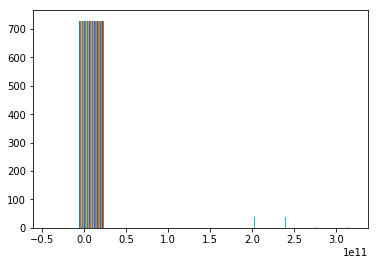

In [269]:
plt.hist(ref_feat1[:,selector.ranking_==1][label==1])
plt.show()

([array([    0., 77640.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.]),
  array([    0., 77640.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.]),
  array([    0., 77640.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.]),
  array([    0., 77640.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.]),
  array([    0., 77640.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.]),
  array([    0., 77640.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.]),
  array([    0., 77640.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.]),
  array([    0., 77640.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.]),
  array([    0., 77640.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.]),
  array([    0., 77640.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.]),


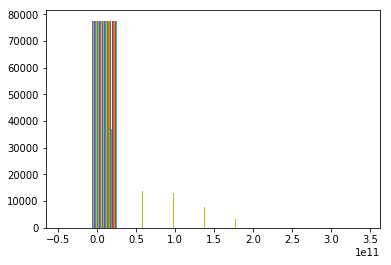

In [270]:
plt.hist(ref_feat1[:,selector.ranking_==1][label==0])
plt.show()